In [2]:
import numpy as np
import cupy as cp

In [3]:

def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert(X.ndim == 2)
    EPS = 10e-5
    X = X-np.mean(X,axis=0,keepdims=True)
    #   covariance matrix
    cov = np.dot(X.T, X)
    # cov = np.cov(X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = cp.linalg.eigh(cp.array(cov))
    print(d)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1. / np.sqrt(cp.asnumpy(d) + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(cp.asnumpy(E), D), cp.asnumpy(E.T))

    X_white = np.dot(X, W)

    return X_white

In [9]:
def zca_whiten_test(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    # sigma = np.dot(X.T, X) 
    sigma = np.cov(X) # [M x M]
    print(sigma.shape)
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,_ = cp.linalg.svd(cp.array(sigma))
    U = cp.asnumpy(U)
    S = cp.asnumpy(S)
    
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 10e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    xZCAMatrix = np.dot(ZCAMatrix, X)
    return xZCAMatrix


In [5]:
import cv2
 
def read_video(path):
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
    
    # Read until video is completed
    frames = None
    while(cap.isOpened()):
    # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
           break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (128,96))
        frame = frame[np.newaxis,:,:].astype(np.float32)/255.0
        frames = frame if frames is None else np.concatenate((frames,frame),axis=0)
    
    cap.release()
    return frames, fps


video_name = "Data_2023-10-22_11-33-39"
frames, fps = read_video('C:/Users/steve/Desktop/809K/data/Data_Test/' + video_name + '.avi')

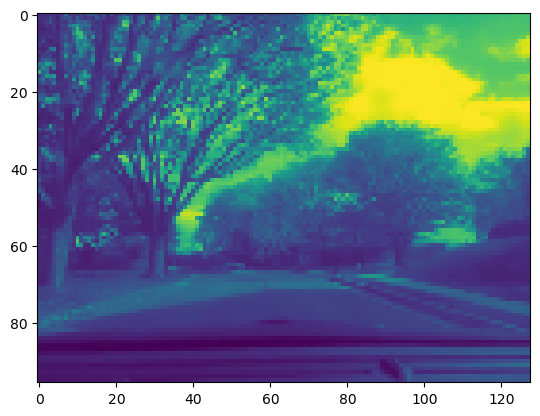

In [6]:
import matplotlib.pyplot as plt

plt.imshow(frames[0,:,:])
plt.show()

In [7]:
frames1 = np.reshape(frames,(frames.shape[0],-1))

In [10]:
frames_w = zca_whiten_test(np.reshape(frames,(frames.shape[0],-1)))

(901, 901)


In [11]:
framew_w2 = np.reshape(frames_w,(frames.shape[0],96,128))


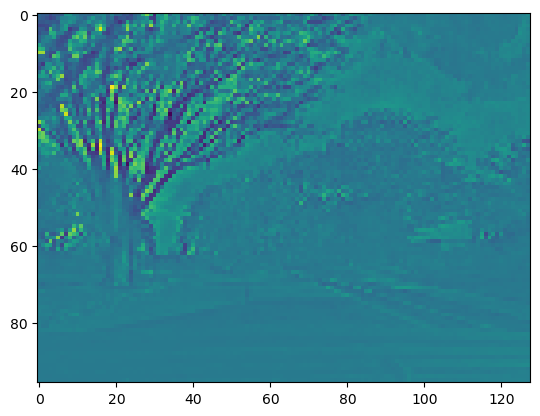

In [12]:
test_img = framew_w2[10,:,:]
#print(test_img)
plt.imshow(test_img)
plt.show()

In [13]:
from tqdm import tqdm

frame_size = (128, 96)

frames_save = ((framew_w2 -(-10))/20)
# frames_save = np.maximum(frames_save, 0.0)
# frames_save = np.minimum(frames_save, 1.0)
frames_save = np.clip(frames_save, 0, 1)
frames_save = (frames_save*255.0).astype(np.uint8)

save_clip = cv2.VideoWriter(video_name + '_zca.avi',  cv2.VideoWriter_fourcc('M','J','P','G'), 15, frame_size) 

for i in tqdm(range(frames_save.shape[0])):
    
    save_clip.write(cv2.cvtColor(frames_save[i], cv2.COLOR_GRAY2BGR))
    
save_clip.release()


100%|██████████| 901/901 [00:00<00:00, 7345.37it/s]
